# How to run this file?
In this file, there are three cells: 'define functions', 'simulation', 'graphing' cell. 
- First, run the 'define functions' cell to define functions.
- After you run 'define functions' cell, you will see 'config parameters' section explains the parameters you can change in the next cell ('simulation' cell).
- After you modify parameters, run the 'simulation' cell. You will see '-------Simulation Start----------',..., until'----------Simulation Finished---------', meaning simulation completed. The processing time depends on the game length you select.
- Finally, run the 'graphing' cell. The result shows dynamics graphs over periods. The top left graph shows payoffs for each strategies over periods; The top right graph shows cdf; the bottom graph shows strategies over periods. 

New added:
- a dynamics with average payoffs compared to the NE payoff.
- modify the selection distance depends on bubble and max(y)
- evaulate sampling

Version 2.3
- modify leaving function (selection rule) and drop trembling if selected player choose not to move.
- new option for arriving function (including general and logit formula) and beta
- new option for replicator

Version 2.4
- In leaving function, the distance is calculated based on purified payoff v1.

Version 2.5
- Implement endogenous logit/linear leaving function w/o purification v1.


In [5]:
#########################################################
########## run this cell to define functions ############
############### 'define functions' cell #################
#########################################################


########## configuration ############
import math

def sim_config_init(initial_distribution = 'uniform', initial_xrange=(2,5), initial_sigma=1,initial_mu=1, trembling=0., num_bots=20, move_percent = 0.1, game_length=1000, 
                    xrange=(2,10), theta=10, signal_form='uniform', signal_xrange=(2,5), signal_sigma=0.5, weight_to_theta=0.5, positive_constant=100, x_bar='mean', percentile=50, exp=False,):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param sampling: int, number of players to sample (give each player an array of random other players to sample), default to None
    :param purification: idiosyncratic shifts of perceived landscape
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param bandwidth: float, smoothing bandwidth, default to None
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    # the initial distribution of x( or action) could be 'uniform' or 'normal' or 'clump'
    config['initial_distribution'] = initial_distribution
    
    # initial variance if use normal distribution
    config['initial_sigma'] = initial_sigma

    # initial mean if use normal distribution
    config['initial_mu'] = initial_mu
    
    # trembling range
    # set to 0 to have no effect
    config['trembling'] = trembling
    
    
    # initial distribution range
    config['initial_xmin'] = initial_xrange[0]
    config['initial_xmax'] = initial_xrange[1]  
    
    # signal uniform distribution range
    config['signal_xmin'] = signal_xrange[0]
    config['signal_xmax'] = signal_xrange[1]  
    
    # action range
    config['xmin'] = xrange[0]
    config['xmax'] = xrange[1]    
    
    # number of bots
    config['num_bots'] = num_bots
    
    # move percentage
    config['move_percent'] = move_percent

    # game length
    config['game_length'] = game_length
    
    
    # theta - state
    config['theta'] = theta
    
    # the signal distribution could be 'uniform' or 'normal'
    config['signal_form'] = signal_form
    
    # theta - state
    config['signal_sigma'] = signal_sigma
    
    # weight assign to theta - r
    config['weight_to_theta'] = weight_to_theta

    # positive part for loss function
    config['positive_constant'] = positive_constant
    
    # x_bar
    config['x_bar'] = x_bar
    
    # percentile
    config['percentile'] = percentile
    
    # whether exponentiate
    config['exp'] = exp
    
    return config

########## functions ############

# import numpy as np



# def get_y(n, strategies, config):
#     num_bots = config['num_bots']
#     theta = config['theta']
#     r = config['weight_to_theta']
#     positive_constant = config['positive_constant']
    
# def get_individual_L(n, strategies, config):
#     num_bots = config['num_bots']
#     theta = config['theta']
#     r = config['weight_to_theta']
#     positive_constant = config['positive_constant']   
#     L = 0
#     for i in range(len(strategies)):
#         L += (strategies[i] - n)**2
#     return L

# def data_logging(var_name_list, round_num, history):
#     for var in var_name_list:
#         history[var, round_num] = eval({var})

#     return history


########## simulation functions ############
import random
import numpy as np
import pandas as pd
import math
# from timing_games_package import Functions as fun

def initialize_player_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;  ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    '''
    # game type for starting distribution: set to 'uniform' or 'normal' for respective distributions
    #For uniform needs to set initial xrange
    #For normal needs to set initial sigma

    initial_distribution = config['initial_distribution']
    num_bots = config['num_bots']
    
    #uniform distribution
    if initial_distribution == 'uniform':
        initial_xmin = config['initial_xmin']
        initial_xmax = config['initial_xmax']
        
        #action for each bot
        strategies_list = []
        
        for i in range(num_bots):
            strategies_list.append(random.random() * (initial_xmax - initial_xmin) + initial_xmin)
        strategies = np.array(strategies_list)
        
    #normal distribution
    elif initial_distribution == 'normal':
        initial_sigma = config['initial_sigma']
        initial_mu = config['initial_mu']
        strategies = np.random.normal(initial_mu, initial_sigma, num_bots)

         


    strategies = np.round(strategies, 2)
    strategies = np.sort(strategies)

#     # apply sampling
#     for i in range(num_bots):
#         if sampling is not None:
#             other_player_index_list = list(range(num_bots))
#             other_player_index_list.remove(i)
#             to_add = random.sample(other_player_index_list, sampling)
#             sample_sets.append(to_add)
            
#     initial_strategies = strategies

    return strategies



def generate_private_signal(config):
    
    theta = config['theta']
    num_bots = config['num_bots']
    signal_form = config['signal_form']
    
    if signal_form == 'uniform':
        signals_list = []
        signal_xmin = config['signal_xmin']
        signal_xmax = config['signal_xmax']
        for i in range(num_bots):
            signals_list.append(random.random() * (signal_xmax - signal_xmin) + signal_xmin)
        signals = np.array(signals_list) 
        
    elif signal_form == 'normal':
        signal_sigma = config['signal_sigma']
        signals = np.random.normal(0, signal_sigma, num_bots)
        signals = signals + theta
    signals = np.round(signals, 2)
    signals = np.sort(signals)
    
    return signals

    
def calculate_payoff(config, strategies, signals):
    num_bots = config['num_bots']
    theta = config['theta']
    r = config['weight_to_theta']
    positive_constant = config['positive_constant']
    x_bar = config['x_bar']
    percent = config['percentile']
    exp = config['exp']
#     #calculate bar{L}
#     L_bar=0
#     for n in strategies:
#         L=get_individual_L(n)
#         L_bar += L
    
#     #calculate utility
#     strategies_y = []
#     for i in range(len(strategies)):
#         L_i = get_individual_L(strategies[i])
#         payoff = positive_constant - (1-r)*(strategies[i]-theta)**2 - r*(L_i - L_bar)
#         strategies_y.append(payoff)


    #payoff
    strategies_y = []
    if exp is False:
        if x_bar == 'mean':
            for i in range(len(strategies)):
                payoff = positive_constant - r*(strategies[i]-signals[i])**2 - (1-r)*(strategies[i]-strategies.mean())**2
                strategies_y.append(payoff)
        else:
            for i in range(len(strategies)):
                payoff = positive_constant - r*(strategies[i]-signals[i])**2 - (1-r)*(strategies[i]-np.percentile(strategies, percent))**2
                strategies_y.append(payoff)
    else:
        for i in range(len(strategies)):
            u = math.exp(-(strategies[i]-signals[i])**2)
            v = math.exp(-(strategies[i]-np.percentile(strategies, percent))**2)
            payoff = u*v
            strategies_y.append(payoff)
    return strategies_y


    
        
def update_strategies(strategies, signals, strategies_y, config):
    
    num_bots = config['num_bots']
    theta = config['theta']
    r = config['weight_to_theta']
    positive_constant = config['positive_constant']
    trembling = config['trembling']
    move_size = round(config['move_percent'] *config['num_bots'])
    xmax = config['xmax']
    xmin = config['xmin']
    x_bar = config['x_bar']
    percent = config['percentile']
    exp = config['exp']
    
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    static_strategies = strategies.copy()
    
    best_strategies_y = max(strategies_y)
    strategies_y = np.array(strategies_y)
    distances_from_best_payoff = best_strategies_y - strategies_y
    players_index = list(range(len(strategies)))
    
    n=0
    selected_player_index = set([])
    while n < move_size:
#         print('players_index is {}'.format(players_index))
#         print('distances_from_best_payoff is {}'.format(distances_from_best_payoff))
        chosen_one = random.choices(players_index, weights=distances_from_best_payoff,k=1)
#         print('chosen_one is {}'.format(chosen_one))
        selected_player_index.update(chosen_one)
#         print('selected_player_index is {}'.format(selected_player_index))
        index = players_index.index(chosen_one[0])
#         print('index is {}'.format(index))
        del players_index[index]
#         print('new players_index is {}'.format(players_index))
        distances_from_best_payoff = np.delete(distances_from_best_payoff, index)
#         print('new distances_from_best_payoff is {}'.format(distances_from_best_payoff))
        n+=1
#         print(n)
        sum_weights = math.fsum(distances_from_best_payoff)
#         print('sum weights is {}'.format(sum_weights))
        if sum_weights == 0:
            break
    if len(selected_player_index) != move_size:
        remaining = random.sample(players_index,k=move_size-n)
#         print('remaining is {}'.format(remaining))
        selected_player_index.update(remaining)
#         print(selected_player_index)

#     print('selected {}'.format(selected_player_index))
    for i in selected_player_index:
        potential_strategies = static_strategies.copy()
#         print('potential_strategies {}'.format(potential_strategies))
        y1 = [] #calculate landscape for selected player
        if exp is False:
            if x_bar == 'mean':
                for val in x:
                    potential_strategies[i] = val
                    payoff = positive_constant - r*(potential_strategies[i]-signals[i])**2 - (1-r)*(potential_strategies[i]-potential_strategies.mean())**2
                    y1.append(payoff)
            else:
                for val in x:
                    potential_strategies[i] = val
                    payoff = positive_constant - r*(potential_strategies[i]-signals[i])**2 - (1-r)*(potential_strategies[i]-np.percentile(potential_strategies, percent))**2
                    y1.append(payoff)
        else:
            for val in x:
                potential_strategies[i] = val
                u = math.exp(-(potential_strategies[i]-signals[i])**2)
                v = math.exp(-(potential_strategies[i]-np.percentile(potential_strategies, percent))**2)
                payoff = u*v
                y1.append(payoff)
                
        best = max(y1)
        # if there are multiple timings with the best payoff, choose randomly
        indices = [k for k, j in enumerate(y1) if j == best]
        best_choice = random.choice(indices)
        best_choice = x[best_choice] 
        
        if best_choice != strategies[i]:    
            strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
#         print('strategies {}'.format(strategies))
    return strategies
            
            
        
           

# from timing_games_package import Simulation
# from timing_games_package.Configuration import sim_config_init
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
plt.style.use('default')

# config parameters (you can change values in the cell below)

`game_type`: game type. It could be 'fear' or 'greed', or 'other'.
- `game_type` is optional for only fear or only greed game. For example, if you specify `game_type='greed'` while $\gamma \leq \rho + 2/3$, the code will override game type you specified and force it to 'fear' instead.
- If you choose 'other', the initial strategies will be selected based on uniform distribution. You need to specify the range `xrange`.

`lgr`: lambda/gamma/rho params: (lambda, gamma, rho)
- `lgr=(10,1.1,0.5)` means (lambda, gamma, rho)=(10, 1.1, 0.5)

||game type|
|--|--|
|$\gamma \leq \rho + 2/3$|only fear game|
|$\rho + 2/3 < \gamma < \rho + 4/3 $|fear or greed equilibrium|
|$\gamma \geq \rho + 4/3 $|only greed|


`sampling`: number of players to sample. Give each player an array of random other players to sample, default to None.
- `sampling=None` means players could observe all other players' moves.
- `sampling=5` means players could only observe 5 other players' moves.

`purification`: idiosyncratic shifts of perceived landscape. It could be 0.1, 0.2 etc.
- u(x)v((1-e)q), with e=2di/(N-1)-d for i=0,...N-1 when num_bots=N. Specifically, d=purification.
- `purification=None` meaning purification is disabled.


`trembling`: trembling range (set to 0 to have no effect. It could be 0.1, 0.2, etc

`bandwidth`: smoothing bandwidth (set None to disable). It could be 0.1, 0.2, etc


`num_bots`: number of bots

`move_percent`: the percent of players that move each period. It could be 0.1, 0.2, etc.
- fully asynchronous if `move_percent=1/number of bots` (meaning only one player moves per period)
- fully synchronous if `move_percent=1.0` (meaning all players move per period)

Example: if `num_bots=20` and `move_percent=0.05`, we have fully asynchronicity; if `num_bots=20` and `move_percent=1.0`, we have fully synchronicity.


`game_length`: game length. Simulation periods

`xrange`: you need to specify x range if the game type is 'other'.



# selected parameters based on theory

|$\lambda$|$\gamma$|$\rho$|game type|rush size|rush time|slow play on|Nah payoff|
|--|--|--|--|--|--|--|--|
|10|1.1|0.5| only fear|q0=0.45|1.26|[1.26,10]| 27.545| 
|10|1.5|0.5| fear equilibrium|q0=0.75|5.51|[5.51,10]| 100.90|
|10|1.5|0.5| greed equilibrium|q1=0.25|14.49|[10,14.49]| 101|
|10|2|0.5| only greed|q1=0.725|15.97|[10,15.97]| 101|
|10|2.5|2| only fear|q0=0.375|6.69|[6.69,10]| 90.9| 
|10|2.5|1.7| fear equilibrium|q0=0.6|7.28|[7.28,10]| 96.2|
|10|2.5|1.7| greed equilibrium|q1=0.1|11.27|[10,11.27]| 101|
|10|2.5|1.3| fear equilibrium|q0=0.9|8.58|[8.58,10]| 107.2|
|10|2.5|1.3| greed equilibrium|q1=0.4|13|[10,13]| 101|
|10|2.5|1| only greed|q1=0.625|14.25|[10,14.25]| 101|
|10|3|2| fear equilibrium|q0=0.75|8.25|[8.25,10]| 101|
|10|3|2| greed equilibrium|q1=0.25|11.74|[10,11.74]| 101|
|10|3.6|2| only greed|q1=0.7|12.85|[10,12.85]| 101|


In [12]:
####################################################################################
########## run this cell to run simulation after you change parameters ############
############################### 'simulation' cell #################################
####################################################################################
from datetime import datetime
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

start=datetime.now()

history = {}
round_idx = 0

# Set up simulation configuration
#####################################
### you can change parameters here ###
#####################################
sim_config = sim_config_init(
    initial_distribution = 'uniform', 
    initial_xrange=(5,15), #use if initial distribution is uniform
    initial_sigma=1, #use if initial distribution is normal
    initial_mu=8, #use if initial distribution is normal
    trembling=0.2, 
    num_bots=200, 
    move_percent = 0.2, 
    game_length=50, 
    xrange=(5,15), 
    theta=10, 
    signal_form='uniform', 
    signal_xrange=(8,12), #use if signal distribution is uniform
    signal_sigma=0.5, #use if signal distribution is normal
    weight_to_theta=0.8, 
    positive_constant=100,
    x_bar = 'mean', #can be mean or percentile
    percentile = 50, #use if x_bar = 'percentile'
    exp=False,
)


# Simulate players' initial strategies and payoffs
strategies = initialize_player_strategies(sim_config)
print(strategies)
signals = generate_private_signal(sim_config)
print(signals)
strategies_y = calculate_payoff(sim_config, strategies, signals)
print(strategies_y)
# Log data for the initial round
history['strategies', round_idx] = strategies.copy()
history['strategies_y', round_idx] = strategies_y
# history['selected_player_index', round_idx] = None


# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

print('----------------Simulation Start----------------')
print('Period 0 done')
while round_idx < max_game_length:
    round_idx += 1
    strategies = update_strategies(strategies, signals, strategies_y, sim_config)
#     print(strategies)
    strategies_y = calculate_payoff(sim_config, strategies, signals)
    # Log data for the round
    history['strategies', round_idx] = strategies.copy()
    history['strategies_y', round_idx] = strategies_y

#     history['selected_player_index', round_idx] = selected_player_index   
    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    
print('----------------Simulation Finished----------------')


print('simulation spent time: {}'.format(datetime.now()-start))

[ 5.06  5.07  5.09  5.1   5.16  5.19  5.28  5.46  5.62  5.72  5.74  5.76
  5.78  5.8   5.86  5.89  5.91  5.91  5.92  5.93  6.02  6.05  6.1   6.11
  6.12  6.18  6.24  6.26  6.32  6.34  6.35  6.37  6.41  6.55  6.56  6.58
  6.66  6.71  6.74  7.    7.01  7.06  7.12  7.2   7.24  7.26  7.3   7.36
  7.54  7.59  7.61  7.62  7.64  7.64  7.65  7.68  7.73  7.73  7.76  7.83
  7.84  7.89  7.9   7.98  8.    8.25  8.26  8.28  8.37  8.45  8.64  8.7
  8.7   8.71  8.78  8.86  8.86  8.87  9.1   9.23  9.46  9.47  9.5   9.55
  9.57  9.62  9.63  9.67  9.69  9.71  9.75  9.81  9.91 10.01 10.06 10.12
 10.14 10.26 10.26 10.33 10.49 10.51 10.52 10.56 10.58 10.61 10.61 10.71
 10.73 10.88 11.   11.03 11.04 11.1  11.23 11.25 11.25 11.32 11.34 11.4
 11.49 11.54 11.55 11.55 11.6  11.63 11.68 11.68 11.71 11.73 11.8  11.93
 11.98 12.01 12.08 12.13 12.13 12.13 12.16 12.17 12.18 12.19 12.24 12.33
 12.34 12.35 12.37 12.43 12.46 12.47 12.54 12.56 12.58 12.6  12.68 12.73
 12.81 12.84 12.89 13.04 13.05 13.09 13.12 13.12 13.2

<IPython.core.display.Javascript object>


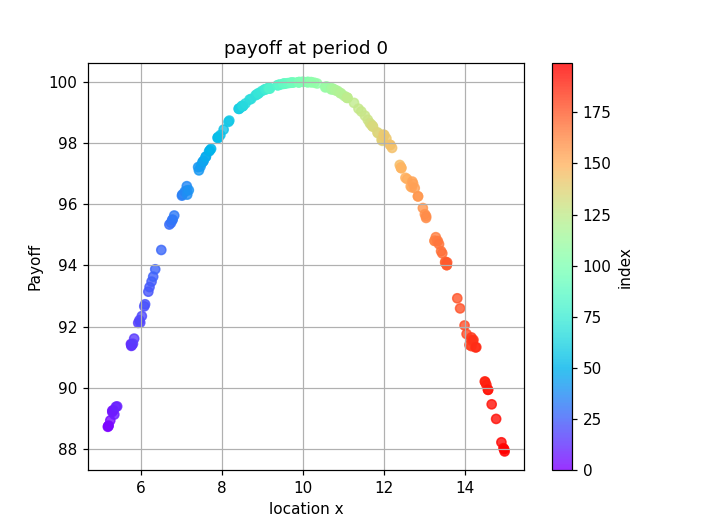

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(history['strategies', 0], history['strategies_y', 0],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.8)
plt.xlabel('location x')
plt.ylabel('Payoff')
plt.title('payoff at period 0')
plt.colorbar(label='index')
plt.grid()
plt.show()

output_name = 'exp_uniform(5,15)_uniformsignal(10,10)_wieght0.2_bots1000_trembling0_percentile50'
plt.savefig(output_name + '_period0.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


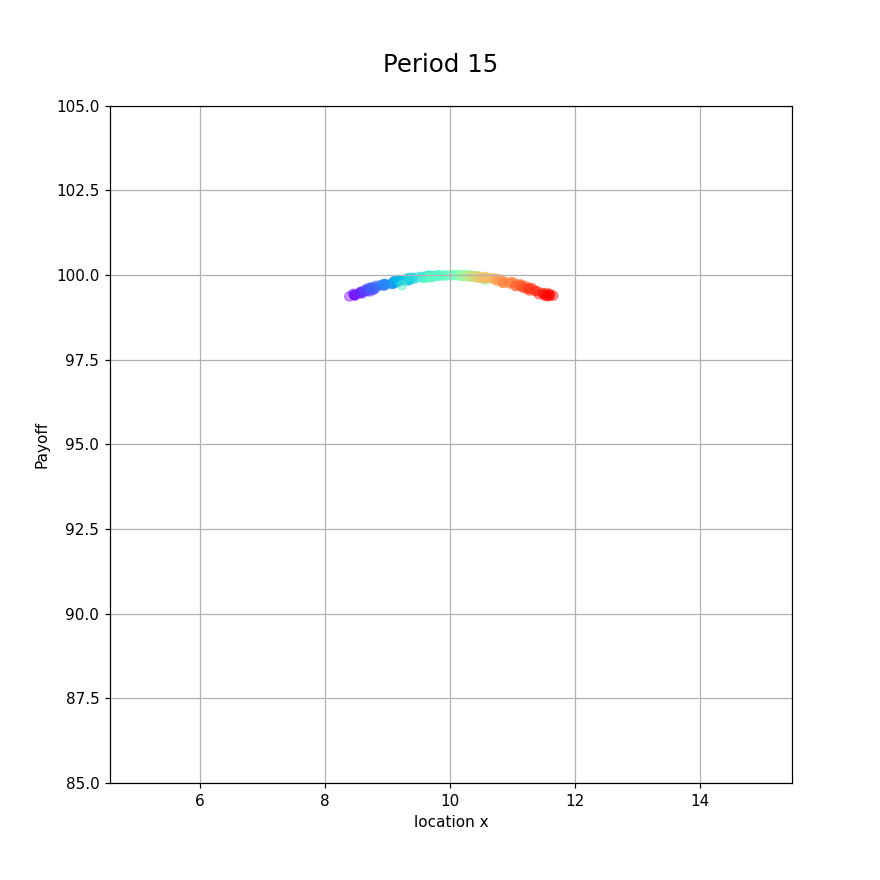

MovieWriter ffmpeg unavailable; using Pillow instead.


Done


In [14]:
range_end=30

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(range_end+1):
#     ax1.clear()
    
    graph = ax1.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('location x')
    ax1.set_ylabel('Payoff')
#     ax1.set_title('payoff')
    ax1.grid()
#     ax1.set_xlim([4, 15])
    ax1.set_ylim([85, 105])
#     ax1.set_ylim([0, 1.2])
    
    plt.pause(0.001)
    ax1.text(0.4, 1.05, 'Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = 'uniform(5,15)_uniformsignal(8,12)_wieght0.8_bots200_trembling0.2_mean50'
animation.save(output_name + '.gif')     
print('Done')

<IPython.core.display.Javascript object>


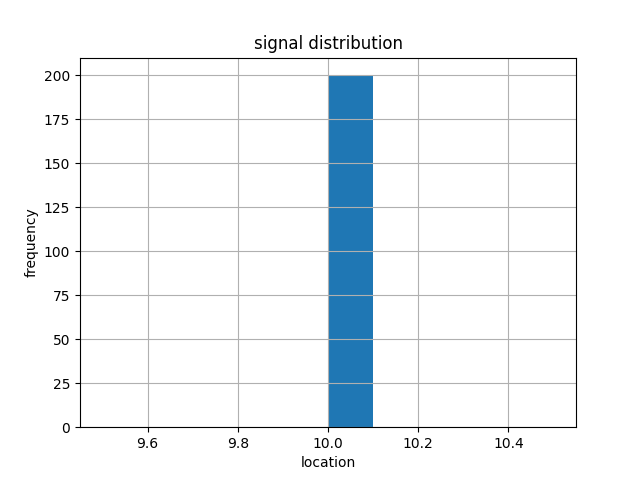

In [72]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

plt.hist(signals)
plt.xlabel('location')
plt.ylabel('frequency')
plt.title('signal distribution')
plt.grid()
plt.show()

output_name = 'exp_uniform(5,15)_uniformsignal(10,10)_wieght0.2_bots1000_trembling0_percentile50'
plt.savefig(output_name + '_signals.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


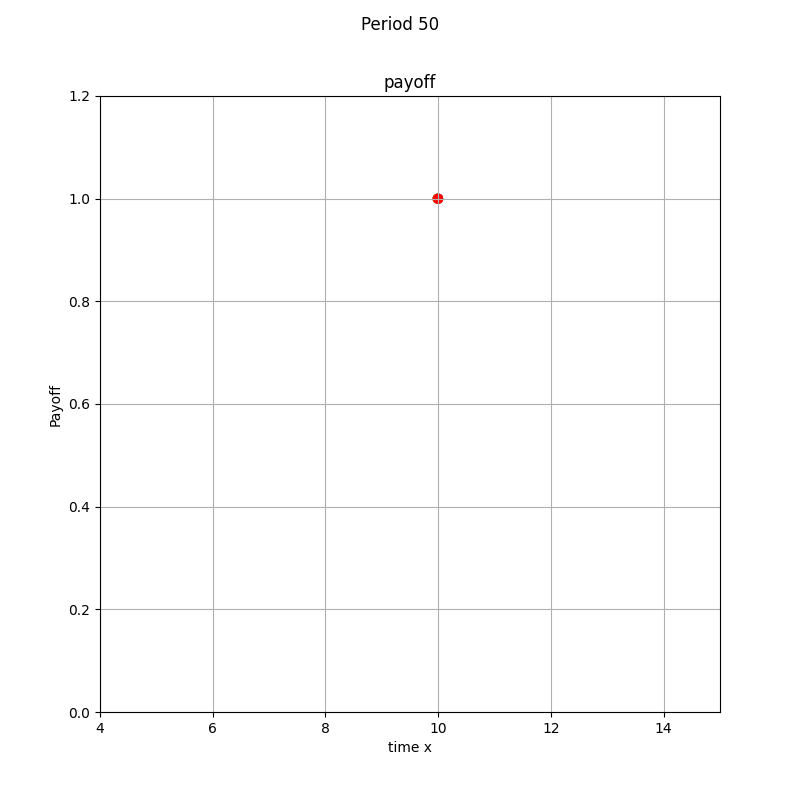

Done


In [68]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


player_index = list(range(sim_config['num_bots']))

fig = plt.figure(figsize=(8,8))
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    fig.clear()
    plt.scatter(history['strategies', i], history['strategies_y', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    plt.xlabel('time x')
    plt.ylabel('Payoff')
    plt.title('payoff')
    plt.grid()
    plt.xlim([4, 15])
    plt.ylim([0, 1.2])
#     plt.ylim([80, 105])
    
    
    plt.pause(0.1)
    fig.suptitle('Period ' + str(i))
    fig.canvas.draw()


print('Done')

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9])
print(a)
print(np.median(a))
print(np.percentile(a,50))
print(np.percentile(a,30))